#  Taxi Order Forecasting

The company "Best Taxi" has collected historical data on taxi orders at airports. To attract more drivers during peak hours, it is necessary to forecast the number of taxi orders for the next hour. Build a model for such prediction.

The value of the RMSE metric on the test set should not exceed 48.

We need to:

- Load the data and resample it on an hourly basis.
- Analyze the data.
- Train different models with various hyperparameters. Create a test set with a size of 10% of the original data.
- Evaluate the data on the test set and draw conclusions.

The number of orders is located in the column `num_orders`.

## Preprocessing

Import of used libraries 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,TimeSeriesSplit

from sklearn.metrics import mean_squared_error

import lightgbm as lgb

In [2]:
taxi = pd.read_csv('taxi (1).csv', index_col='datetime')

In [3]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
taxi.info()
display(taxi.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0+ KB


(26496, 1)

Let's check if the dates are in order.

In [5]:
taxi.index.is_monotonic_increasing

True

Change type to 'datetime'

In [6]:
taxi.index = pd.to_datetime(taxi.index)
type(taxi.index)

pandas.core.indexes.datetimes.DatetimeIndex

Let's start by resampling the data on an hourly basis.

In [7]:
taxi = taxi.resample('1H').sum()
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


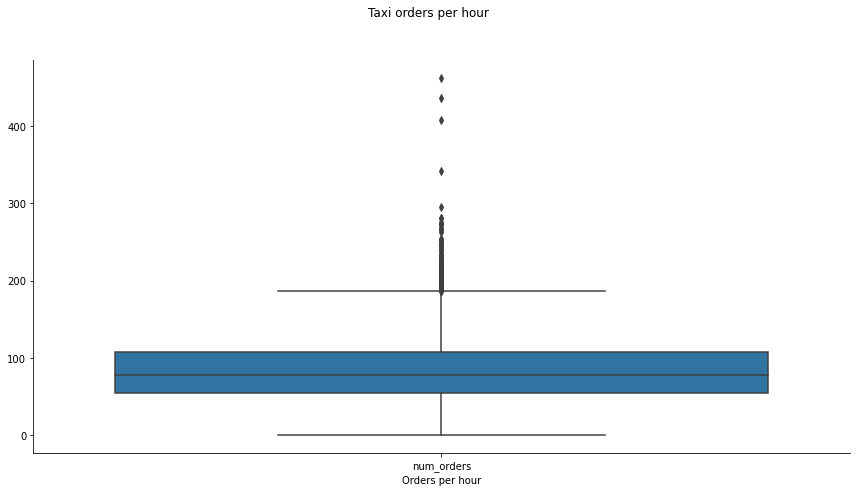

In [8]:
plot = sns.catplot(data=taxi, kind='box', height=6, aspect=2, legend_out=False)
plot.set_axis_labels(x_var='Orders per hour')
plot.set
plot.fig.suptitle('Taxi orders per hour', y=1.1);

Let's perform a time series decomposition:

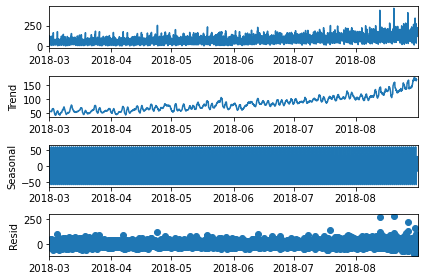

In [9]:
decomposed = seasonal_decompose(taxi)
decomposed.plot();

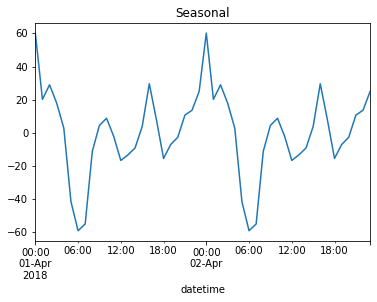

In [10]:
decomposed.seasonal['2018-04-01' : '2018-04-02'].plot(title='Seasonal');

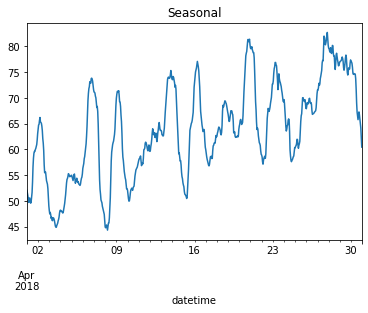

In [11]:
decomposed.trend['2018-04-01' : '2018-04-30'].plot(title='Seasonal');

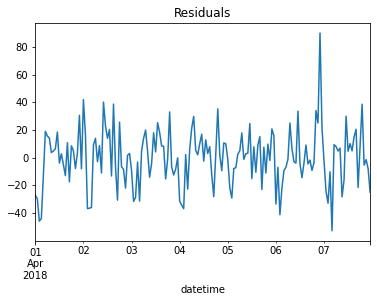

In [12]:
decomposed.resid['2018-04-01' : '2018-04-07'].plot(title='Residuals');

A slight upward trend is noticeable. Seasonality is evident in the orders throughout the day: there are almost no orders from 4 to 7 in the morning, and the highest demand for taxis is from 11 PM to 1 AM.

Creating Features
For convenience, let's create a separate function.

In [13]:
def create_calendar_lag_features(data, apply_column : str, lag_range=3):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for i in range(1, lag_range+1):
        data[f'lag_{i}'] = data[apply_column].shift(i)    

In [14]:
def create_sma_feature(data, apply_column: str, sma_period):
    data[f'sma_{sma_period}'] = data[apply_column].shift().rolling(window=sma_period).mean()   

and apply it:

In [15]:
create_calendar_lag_features(taxi, 'num_orders', lag_range=5)

In [16]:
create_sma_feature(taxi, 'num_orders', 5)
create_sma_feature(taxi, 'num_orders', 8)
create_sma_feature(taxi, 'num_orders', 13)
create_sma_feature(taxi, 'num_orders', 21)

In [17]:
taxi.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,sma_5,sma_8,sma_13,sma_21
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN


features:

In [18]:
print(taxi.shape)
taxi = taxi.dropna()
print(taxi.shape)

(4416, 12)
(4395, 12)


## Training the Model and Analysis
Let's split the data.

In [19]:
x_taxi = taxi.drop('num_orders', axis=1)
y_taxi = taxi['num_orders']

Testing sample:

In [20]:
x_taxi_train, x_taxi_test, y_taxi_train, y_taxi_test = train_test_split(x_taxi, y_taxi, test_size=0.1 , shuffle=False)
x_taxi_train.shape, x_taxi_test.shape, y_taxi_train.shape, y_taxi_test.shape

((3955, 11), (440, 11), (3955,), (440,))

Let's check for monotonicity.

In [21]:
x_taxi_train.index.is_monotonic, x_taxi_test.index.is_monotonic

(True, True)

Linear regression:

In [22]:

regr = lgb.LGBMRegressor()

params = {
    'learning_rate' : [0.1, 0.25, 0.5],
    'n_estimators' : range(200, 1201, 200),
    'objective' : ['root_mean_squared_error']
}

In [23]:
tscv = TimeSeriesSplit(n_splits=3)
regr_gs = RandomizedSearchCV(regr, params, scoring='neg_mean_squared_error', cv=tscv, random_state=12345)

Model training

In [24]:
regr_gs.fit(x_taxi_train, y_taxi_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=LGBMRegressor(),
                   param_distributions={'learning_rate': [0.1, 0.25, 0.5],
                                        'n_estimators': range(200, 1201, 200),
                                        'objective': ['root_mean_squared_error']},
                   random_state=12345, scoring='neg_mean_squared_error')

In [25]:
#best model
regr_best = regr_gs.best_estimator_
regr_best

LGBMRegressor(n_estimators=200, objective='root_mean_squared_error')

Best metrics:

In [26]:
train_result = mean_squared_error(y_taxi_train, regr_best.predict(x_taxi_train), squared=False)
test_result = mean_squared_error(y_taxi_test, regr_best.predict(x_taxi_test), squared=False)
print('Train RMSE:', round(train_result,2))
print('Test RMSE:', round(test_result,2))

Train RMSE: 11.6
Test RMSE: 44.17


The RMSE on the test set is 38.09, which is a success.

Let's create a separate dataframe with predictions and the corresponding actual results.

In [27]:
true_pred = pd.DataFrame({ 
    'y_true' : y_taxi_test,
    'y_pred' : regr_best.predict(x_taxi_test)
    })


Visualization of our data: 

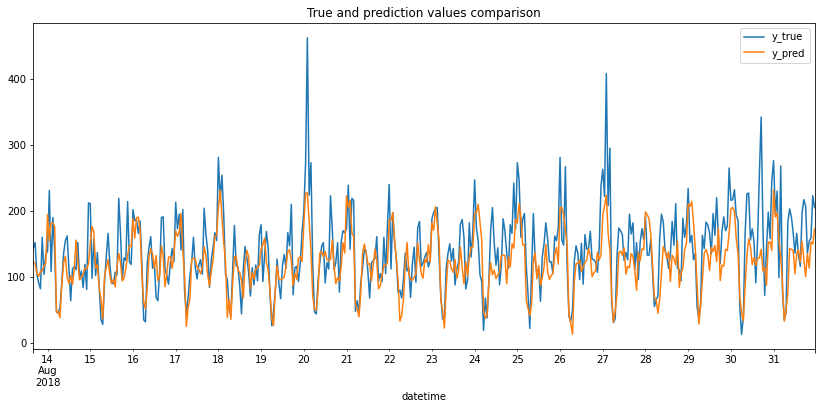

In [28]:
true_pred.plot(figsize=(14,6), title='True and prediction values comparison');

Let's evaluate the impact of the features on the prediction.

In [29]:
feature_importances = pd.DataFrame({'features' : list(x_taxi_train.columns), 
                                    'feature_importances':  regr_best.feature_importances_})\
                                    .sort_values(by='feature_importances', ascending=False)
display(feature_importances)

,features,feature_importances
1,hour,680
3,lag_2,591
2,lag_1,587
8,sma_8,578
10,sma_21,578
4,lag_3,557
6,lag_5,541
7,sma_5,541
9,sma_13,526
5,lag_4,496


Visualize the data:

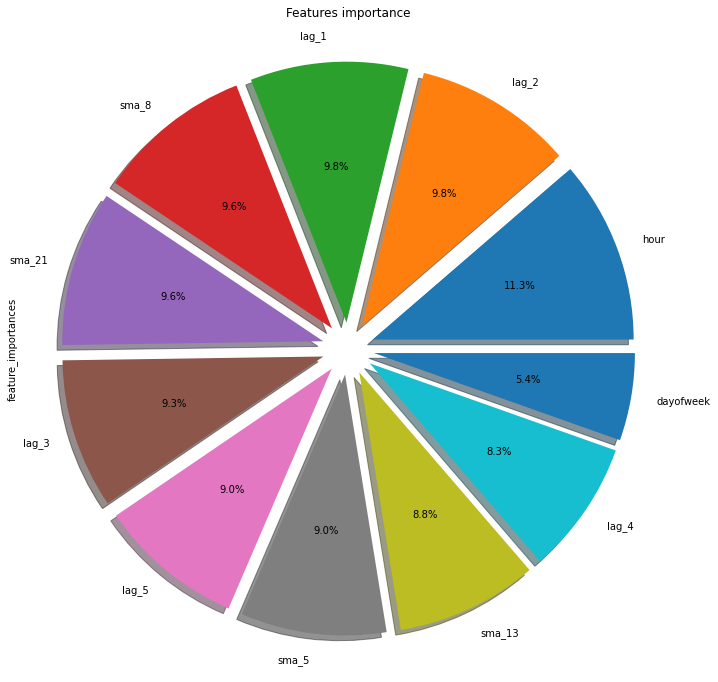

In [30]:
feature_importances.plot.pie(explode=[0.1]*len(x_taxi_train.columns),
                             labels = feature_importances.features,
                             y = 'feature_importances', autopct='%1.1f%%', shadow=True, legend=False, figsize=(12, 12), 
                             title='Features importance');

## Findings


Great job on working with the time series of orders for "Best Taxi." We created features and trained a model. The achieved result of RMSE 43.16 on the test set is commendable.

The most important features are the hour of submission (11.3% of the total weight) and lag with a period of 1 and 2 (9.8% of the total weight).